# Combining LabView BCS with Bluesky

## Overview

This notebook demonstrates how the LabView Beamline Control System API can be used to implement a "Single Motor Scan" as an `ophyd` device. Furthermore, this "Single Motor Scan" device can be initiated by the `bluesky` Run Engine as a `fly` plan with data avaliable in a bluesky run document.

### Brief Summary

The bluesky `fly` plan will cede control to an `ophyd` "[Fly-able Interface](http://nsls-ii.github.io/ophyd/architecture.html#fly-able-interface)" (e.g., [FlyerInterface](https://github.com/bluesky/ophyd/blob/dd4b3e389a0202ecacce39fc3965d703c616b0d4/ophyd/flyers.py#L17)) to collect data asynchronously, and then return data as "[event](https://blueskyproject.io/event-model/data-model.html#event-document)" documents.

The "Fly-able Interface" must:

1. `kickoff()` the scan
2. `complete()` data collection for the scan
3. `describe_collect()`: provide a descriptor for the data that is being collected
4. `collect()`: yield event document(s) that contain the data

More details about this concept of embedding external control system scans into bluesky can be found in [this example notebook](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb).

This example uses a _synchronous/blocking_ version of the BCS-API library (BCSz_sync.py), which is otherwise identical to the asynchronous version (BCSz.py). The blocking version was created because the bluesky Run Engine does not currently use `asyncio` `await` directive for the Fly-able interface methods.

## Credits

This example builds heavily upon two recently published works, as well as the many developers and contributors to the bluesky and BCS projects.

* [BCS-API](http://bcsapi.als.lbl.gov:3080): ZeroMQ library and python bindings (BCSz.py) developed by [Damon English](https://github.com/daenglis) for interfacing with the Advanced Light Source's BCS control system.
* [`sscan as 1D Flyer`](https://github.com/BCDA-APS/bluesky_training/blob/31-sscan-1D-as-flyer/sscan_1d_flyer.ipynb) example published by [Pete Jemian](https://github.com/prjemian) to demonstrate how the bluesky fly plan can be used to initiate scans and report data from external control systems (in that case, the EPICS sscan record).

# Prepare the notebook settings

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib
%matplotlib notebook

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
try:
    theNotebook
except NameError as e:
    theNotebook = "BCS-API_07_BlueskyFlying_FlyingBeamlineEnergy_BcszSync_nb"
    theNotebook

'BCS-API_07_BlueskyFlying_FlyingBeamlineEnergy_BcszSync_nb'

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Setup bluesky

In [6]:
from bluesky import RunEngine

RE = RunEngine({})

In [7]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
bec_token = RE.subscribe(bec)
bec.enable_table()  # Print hinted readings from the ‘primary’ stream in a LiveTable

# Make plots update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

In [8]:
from dotenv import load_dotenv

load_dotenv()  # import environment variables from .env

True

In [9]:
from databroker import Broker
db = Broker.named('TEST')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

1

In [10]:
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()

In [11]:
RE.md['notebook'] = theNotebook
RE.md

{'versions': {'ophyd': '1.6.1', 'bluesky': '1.6.7'},
 'notebook': 'BCS-API_07_BlueskyFlying_FlyingBeamlineEnergy_BcszSync_nb'}

# Setup BCS-API

In [12]:
# These first two are necessary to use the API
import asyncio
import BCSz_sync

# The rest of the imports are for the Example program
import time
import random

# for working with images
from PIL import Image
import io
from IPython.display import display # to display images

# for plotting and working with files
import pandas as pd
import matplotlib.pyplot as plt
import os

In [13]:
from numpy import nan

## Helper classes and functions for reading data files

In [14]:
def find_bcs_data(data):
    """
    Keep trying to import the data into pandas until success
    The older BCS scans (so called 'Beamline Scans') have a variably sized header.
    """
    for skrows in range(30):
        data.seek(0)
        try:
            df = pd.read_csv(data, sep='\t', skiprows=skrows, nrows=10)
            df['Time (s)']
            break
        except (pd.errors.ParserError, KeyError):
            pass # try again with skrows +=1

    data.seek(0)
    return skrows


def plot_bcs_file(file_text='', plot_title='', x='Time (s)', y=None):
    """Display example plot for API testing"""
    data = io.StringIO(file_text)
    skip_rows = find_bcs_data(data)
    df = pd.read_csv(data, sep='\t', skiprows=skip_rows)
    print(df.columns)
    df.drop(0, inplace=True)
    print(df.head())

    if not y:
        y = random.choice(df.columns)

    df.plot(kind='scatter', x=x, y=y)
    plt.title(plot_title)
    plt.show()
    return df

# Connect to BCS server

In [15]:
bl402bcs = BCSz_sync.BCSServer()

bl402bcs.connect(addr=str(os.environ["BCS_SERVER"]), port=int(os.environ["BCS_PORT"]))

Server Public Key b':<:F[m>!ig[5IrX75cn+zp5oR1JpVoB]Q54e6+{T'


---
# PAUSE to check that beamline computer is available for testing

No, seriously!  Ensure that no one else is using the beamline.

---

# Scan motors, read data
## Careful!!!  This is moving real motors on the beamline

# Define Ophyd devices for BCS + Bluesky

In [16]:
from ophyd import Device, Component, Signal
from ophyd.status import DeviceStatus, SubscriptionStatus
from ophyd.flyers import FlyerInterface

## Ophyd device for BCS Single Motor Flying Scan

In [17]:
class BcsSingleMotorFlyingScan(Device):
    """
    BCS Single Motor Flying Scan (continuous acquisition) as an Ophyd device
    """
    
    # Signals to enable subscriptions for scan setup
    motor_name = Component(Signal, kind="config", value='')
    first_value = Component(Signal, kind="config", value=nan)
    last_value = Component(Signal, kind="config", value=nan)
    step_value = Component(Signal, kind="config", value=nan)
    velocity = Component(Signal, kind="config", value=0.)
    num_scans = Component(Signal, kind="config", value=1)
    bidirectional = Component(Signal, kind="config", value=False)
    final_move = Component(Signal, kind="config", value="Stay")
    memo = Component(Signal, kind="config", value='')
    filename_pattern = Component(Signal,kind="config", value="*.txt")
    
    # Signals to enable subscriptions/polling for scan status
    ready = Component(Signal, kind="omitted", value=False)
    busy = Component(Signal, kind="omitted", value=False)
    done = Component(Signal, kind="omitted", value=True)
    execute_scan = Component(Signal, kind="omitted", value=True)
    data_path = Component(Signal, kind="normal", value='')


    def scan_setup(
            self, *, 
            # server: str, port: int, 
            bcs_server: BCSz_sync.BCSServer, 
            motor: str, start: float, stop: float, step: float, 
            velocity: float = 0., 
            num_scans: int = 1, bidirect: bool = False, 
            final: str = "Stay",
            memo: str = '',
            filename_pattern: str = "*.txt", 
            **kwargs):
        """Configure a BCS Single Motor Flying Scan"""
        
        # TODO: Check that bcs_server is connected
        self._bcs = bcs_server
        
        self.motor_name.put(motor)
        self.first_value.put(start)
        self.last_value.put(stop)
        self.step_value.put(step)
        self.velocity.put(velocity)
        self.num_scans.put(num_scans)
        self.bidirectional.put(bidirect)
        self.final_move.put(final)
        self.memo.put(memo)
        self.filename_pattern.put(filename_pattern)
        
        # Scan is configured and ready to execute
        self.ready.put(True)


    def set(self, value, **kwargs):
        """interface to use bps.mv()"""
        if value != 1:
            return
        if self.ready.get():
            bcs_st = self._bcs.scan_status()
            self.busy.put(bcs_st["running_scan"])
        if (not self.ready.get()) or (self.busy.get()):
            # TODO: Raise Warning that scan is not ready
            return
        
        # Workaround until implemented in BCS Flying Scan API
        velocity_value = self.velocity.get()
        if (velocity_value == 0) and (self.motor_name.get() == "Beamline Energy"):
            velocity_value = 0.01  # mm/sec for EPU Gap

        async def check_for_acquire_done(self):
            bcs_st = self._bcs.scan_status()
            while bcs_st["running_scan"]:
                await asyncio.sleep(0.1)
                bcs_st = self._bcs.scan_status()
            else:
                # bcs_st = self._bcs.scan_status()
                print("Scan is finshed!")
                # print(f"{bcs_st =}...")
                self.data_path.put(os.path.join(bcs_st["Log Directory"], bcs_st["Last Filename"]))
                # print(f"{self.data_path.get() =}")
                self.done.put(True)
                self.busy.put(False)
                
        def check_value(*, old_value, value, **kwargs):
            "Return True when the acquisition is complete, False otherwise."
            return (value and not old_value)
        
        status = SubscriptionStatus(self.done, check_value)
        
        self.execute_scan.put(True)
        self._bcs.sc_single_motor_flying_scan(
            x_motor=self.motor_name.get(), 
            start=self.first_value.get(), 
            stop=self.last_value.get(), 
            increment=self.step_value.get(), 
            velocity_units=velocity_value, 
            number_of_scans=self.num_scans.get(),
            bidirect=self.bidirectional.get(),
            at_end_of_scan=self.final_move.get(), 
            description=self.memo.get(),
            file_pattern=self.filename_pattern.get(),
            )
        self.busy.put(True)
        self.done.put(False)
        # Give the scanner time to start
        time.sleep(1)  # TODO: Is this needed?
        self.execute_scan.put(False)
        acquire_task = asyncio.create_task(check_for_acquire_done(self))
        # acquire_task.add_done_callback()
        
        return status

In [18]:
ssFlyBeamlineEnergy = BcsSingleMotorFlyingScan("BCS402:", name="ssFlyBeamlineEnergy")

In [19]:
ssFlyBeamlineEnergy.scan_setup(
        bcs_server=bl402bcs, 
        motor="Beamline Energy", start=845., stop=860., step=0.05, velocity=0.,
    )

In [20]:
ssFlyBeamlineEnergy.get()

BcsSingleMotorFlyingScanTuple(motor_name='Beamline Energy', first_value=845.0, last_value=860.0, step_value=0.05, velocity=0.0, num_scans=1, bidirectional=False, final_move='Stay', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_path='')

### Usying sycnchronous BCSs library

In [21]:
ssFlyBeamlineEnergy.set(1)

SubscriptionStatus(device=ssFlyBeamlineEnergy_done, done=False, success=False)

In [22]:
# Wait for scan to finish
while ssFlyBeamlineEnergy.busy.get():
    await asyncio.sleep(0.5)
    print("...", end=' ')

... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... Scan is finshed!
... 

In [23]:
ssFlyBeamlineEnergy.busy.get()

False

In [24]:
ssFlyBeamlineEnergy.done.get()

True

In [25]:
ssFlyBeamlineEnergy.data_path.get()

'C:\\Beamline Controls\\BCS Setup Data\\211022\\SigScan 000133.txt'

## Helper functions for converting BCS data to Bluesky event model data

In [26]:
from bcs_events import *

In [27]:
from datetime import datetime
import event_model

## Ophyd flyer to run BCS Single Motor Scan as a Bluesky "flying" scan

In [28]:
class BcsSigFlyScanFlyer(FlyerInterface, BcsSingleMotorFlyingScan):
    '''Example of BCS Single Motor Flying Scan accessed through Bluesky'''
    
    yield_array_events = Component(Signal, kind="config", value=True)

    def __init__(self, *args, **kwargs):
        self._acquiring = False
        self._paused = False

        super().__init__(*args, **kwargs)
        
    def stage(self):
        super().stage()
        # self.select_channels()

    def unstage(self):
        super().unstage()
        # self.select_channels()

    def read_configuration(self):
        return {}

    def describe_configuration(self):
        return {}

    def kickoff(self):
        """Start the scan."""
        self.stage()
        time.sleep(0.1)

        # Check for currently running scan
        bcs_st = self._bcs.scan_status()
        if bcs_st["running_scan"]:
            raise RuntimeError("Cannot start scan. Another scan is already running.")
        
        self.set(1)
        self._acquiring = True
        self._paused = False

        status = DeviceStatus(self)
        status.set_finished()  # means that kickoff was successful
        return status

    def complete(self):
        """Wait for sscan to complete."""
        logging.info("complete() starting")
        if not self._acquiring:
            raise RuntimeError("Not acquiring")

        # status = DeviceStatus(self)
        # cb_started = False

        def is_scan_complete(*, old_value, value, **kwargs):
            "Return True when the acquisition is complete, False otherwise."
            # value = bool(value)
            if self._acquiring and value and not old_value:
                logging.info("complete() ending")
                self.unstage()
                self._acquiring = False
                return True
            return False

        status = SubscriptionStatus(self.done, is_scan_complete)
        
        return status

    def describe_collect(self):
        """
        Provide schema & meta-data from collect().
        
        http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
        """
        # TODO: Add hinted signals
        
        ai_names = self._bcs.list_ais()['names']
        
        scan_motor = self.motor_name.get()
        scan_channels = [
            "Time of Day", 
            "Time (s)", 
            f"{scan_motor}", 
            ] + ai_names
      
        # DataFrame enables convenience functions from 'bcs_events'
        data_df = pd.DataFrame(columns=scan_channels)

        sanitize_event_data_keys = {col: sanitize_key(col) 
            for col in data_df.columns[1:].values}

        descriptor_keys = get_descriptor_keys(
            data_df, 
            sanitize_event_data_keys,
            data_src="Inferred from AI List")
        
        if self.yield_array_events.get():
            # This is only for array events
            reading_size = 1 + (self.last_value.get() - self.first_value.get()) / self.step_value.get()
            array_descriptor_keys = {
                key: prepend_dimension_to_descriptor_key(
                    key=value, size=int(reading_size), dim_name="reading") 
                for (key, value) in descriptor_keys.items()
            }
            descriptor_keys = array_descriptor_keys
        
        event_stream_name = "primary"
        
        return {event_stream_name: descriptor_keys}

    def collect(self):
        """
        Retrieve all collected data (after complete()).
        
        Retrieve data from the flyer as proto-events.
        http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
        """
        if self._acquiring:
            raise RuntimeError("Acquisition still in progress. Call complete() first.")
        
        def get_data_from_scan(self):
            """Extract data from scan output file; return as PANDAS DataFrame."""
            file_path = self.data_path.get()
            if not file_path:
                raise RuntimeError("There is no scan data. Call kickoff() first.")
            
            file_text = self._bcs.get_text_file(file_path)['text']

            # Get date from BCS data file header
            with io.StringIO(file_text) as data_file:
                data_file_date_str = data_file.readline().strip().split("Date: ", 1)[1]
                data_date = datetime.strptime(data_file_date_str, "%m/%d/%Y").date()
                self._data_date = data_date
                
            data = io.StringIO(file_text)
            skip_rows = find_bcs_data(data)
            df = pd.read_csv(data, sep='\t', skiprows=skip_rows)
            return df

        def generate_scan_data_events(self):
            """Get the entire scan data and yield bluesky events."""
            data_df = get_data_from_scan(self)
            num_points = len(data_df)
            
            # Run info will not be used by fly() plan
            # ...enables convenience functions from 'bcs_events'
            run_bundle = event_model.compose_run()
            event_stream_name = 'primary'

            sanitize_event_data_keys = {col: sanitize_key(col) 
                for col in data_df.columns[1:].values}

            descriptor_keys = get_descriptor_keys(
                data_df, 
                sanitize_event_data_keys,
                data_src=self.data_path.get())
    
            stream_descriptor = run_bundle.compose_descriptor(
                data_keys=descriptor_keys,
                name=event_stream_name,
                )

            # Get date from BCS data file header
#             with io.StringIO(self.data_path.get()) as data_file:
#                 data_file_date_str = data_file.readline().strip().split("Date: ", 1)[1]
#                 data_date = datetime.strptime(data_file_date_str, "%m/%d/%Y").date()
            data_date = self._data_date
    
            if self.yield_array_events.get():
                # This is only for array events
                
                data_df = add_timestamps(data_df, data_date, inplace=True)
                data_df.drop('Time of Day', axis=1, inplace=True)  # Redundant; have timestamps
                timestamp_col="timestamp"
                
                timestamp = data_df.iloc[0][timestamp_col]
                data_df.drop(timestamp_col, axis=1, inplace=True, errors="ignore")
            
                event = make_array_event(
                    data_df, timestamp, sanitize_event_data_keys, stream_descriptor)

                # yield 'event', event
                yield event
        
            
            else:
                data_df = get_timestamps(data_df, data_date, inplace=True)

                def get_bundled_event(data_row):
                    return get_event(
                        data_row, sanitize_event_data_keys, stream_descriptor)

                # Pack events into an event_page
                events = data_df.apply(get_bundled_event, axis='columns').values

                # yield 'event_page', event_model.pack_event_page(*events)

                for event in events:
                    # yield 'event', event
                    yield dict(
                        seq_num=event["seq_num"],
                        time=event["time"],
                        data=event["data"],
                        timestamps=event["timestamps"],
                    )

        yield from generate_scan_data_events(self)
        self.unstage()

In [29]:
fly_FlyBeamlineEnergy = BcsSigFlyScanFlyer("BCS402:", name="ssflyFlyBeamlineEnergy")
fly_FlyBeamlineEnergy.scan_setup(
        bcs_server=bl402bcs, 
        motor="Beamline Energy", start=845., stop=860., step=0.05, velocity=0.,
    )

In [31]:
fly_FlyBeamlineEnergy.data_path.put('C:\\Beamline Controls\\BCS Setup Data\\211022\\SigScan 000133.txt')

In [32]:
fly_FlyBeamlineEnergy.describe_collect()

{'primary': {'Time (s)': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'sec',
   'dims': ['reading']},
  'Beamline Energy': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'eV',
   'dims': ['reading']},
  'I0 BL': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'counts / sec',
   'dims': ['reading']},
  'I0 ES': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'counts / sec',
   'dims': ['reading']},
  'EY': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'counts / sec',
   'dims': ['reading']},
  'LY': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'counts / sec',
   'dims': ['reading']},
  'FY': {'dtype': 'number',
   'source': 'Inferred from AI List',
   'shape': [301],
   'units': 'counts / sec',
   'dims': ['reading']},
  'EY SCVM': {'dt

In [33]:
# for doc_type, doc in fly_FlyBeamlineEnergy.collect():
#     print(doc_type)
#     print(doc)

for event_reading in fly_FlyBeamlineEnergy.collect():
    print(event_reading)

{'uid': 'e2ab3220-f0e3-45d6-85d6-d8543d5ed363', 'time': 1634953403.5594962, 'data': {'Time (s)': array([67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334, 67.334,
       67.334, 67.334, 67.334, 67.334, 67.334, 67.3

       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, 'timestamps': {'Time (s)': 1634953367.0, 'Beamline Energy': 1634953367.0, 'I0 BL': 1634953367.0, 'I0 ES': 1634953367.0, 'EY': 1634953367.0, 'LY': 1634953367.0, 'FY': 1634953367.0, 'EY SCVM': 1634953367.0, 'LY SCVM': 1634953367.0, 'Clock': 1634953367.0, 'Original Clock': 1634953367.0, 'Captured Mono Energy': 1634953367.0, 'Energy': 1634953367.0, 'Polarization': 1634953367.0, 'Beam Current': 1634953367.0, 'Temp A': 1634953367.0, 'Temp B': 1634953367.0, 'Temp HT': 1634953367.0, 'X': 1634953367.0, 'Y': 1634953367.0, 'Z': 1634953367.0, 'Theta': 1634953367.0, 'M206 Pitch': 1634953367.0, 'I0 BL Amp (nA)': 1634953367.0, 'I0 ES Amp (nA)': 1634953367.0, 'EY Amp (nA)': 1634953367.0, 'LY Amp (nA)': 1634953367.0, 'FY Amp (nA)': 1634953367.0, 'EY SCVM Amp (nA)': 1634953367.0, 'LY SCVM Amp (nA)': 1634953367.0, 'EPU Energy': 1634953367.0, 'EPU Gap': 1634953367.0, 'EPU Phase': 1634953367.0, 'EPU A': 1634953367.0, 'EPU B': 1634953367.0, 'EPU Harm

### Run the Bluesky flying plan

In [34]:
fly_FlyBeamlineEnergy = BcsSigFlyScanFlyer("BCS402:", name="ssflyFlyBeamlineEnergy")

In [35]:
fly_FlyBeamlineEnergy.scan_setup(
        bcs_server=bl402bcs, 
        motor="Beamline Energy", start=845., stop=860., step=0.05, velocity=0.,
    )

In [36]:
fly_FlyBeamlineEnergy.get()

BcsSigFlyScanFlyerTuple(motor_name='Beamline Energy', first_value=845.0, last_value=860.0, step_value=0.05, velocity=0.0, num_scans=1, bidirectional=False, final_move='Stay', memo='', filename_pattern='*.txt', ready=True, busy=False, done=True, execute_scan=True, data_path='', yield_array_events=True)

In [37]:
from bluesky.plans import fly

RE(fly([fly_FlyBeamlineEnergy], md=dict(purpose="demo bluesky fly plan with BCS Single Motor Flying Scan")))



Transient Scan ID: 1     Time: 2021-10-22 18:43:28
Persistent Unique Scan ID: '9d1edbb1-2b2a-40af-bcde-9dfbcfd7ee04'


INFO:root:complete() starting


ssflyFlyBeamlineEnergy_done [In progress. No progress bar available.]                                                  
Scan is finshed!


INFO:root:complete() ending


ssflyFlyBeamlineEnergy_done [In progress. No progress bar available.]                                                  
                                                                                                                       
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+


C:\Users\admin\miniconda3\envs\bluesky\lib\site-packages\event_model\__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+
generator fly ['9d1edbb1'] (scan num: 1)





INFO:bluesky.RE.state:Change state on <bluesky.run_engine.RunEngine object at 0x00000183175CA760> from 'running' -> 'idle'
INFO:bluesky:Cleaned up from plan <generator object fly at 0x00000183204AB270>


('9d1edbb1-2b2a-40af-bcde-9dfbcfd7ee04',)

In [38]:
fly_FlyBeamlineEnergy.busy.get()
fly_FlyBeamlineEnergy.done.get()
fly_FlyBeamlineEnergy.data_path.get()

False

True

'C:\\Beamline Controls\\BCS Setup Data\\211022\\SigScan 000134.txt'

<IPython.core.display.Javascript object>


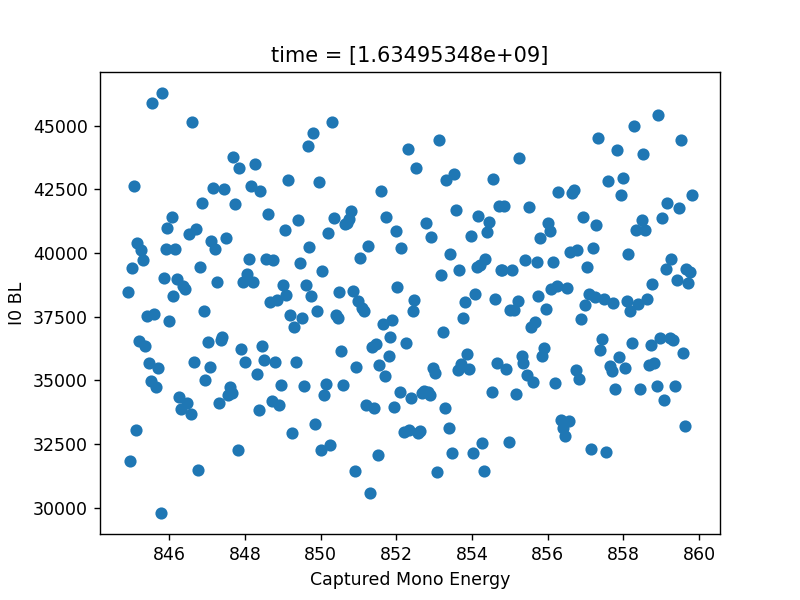

In [39]:
run = db.v2[-1]
data = run.primary.read()
data.plot.scatter("Captured Mono Energy", "I0 BL")

<IPython.core.display.Javascript object>


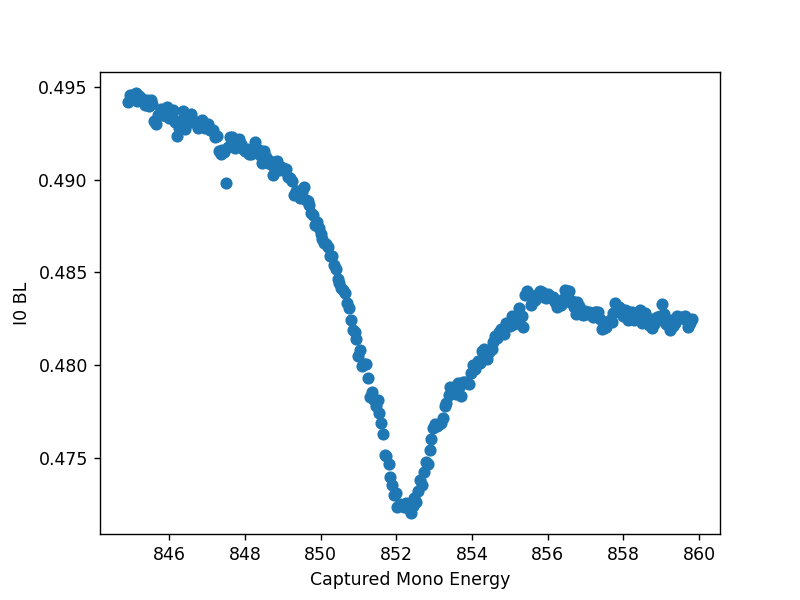

Text(0.5, 0, 'Captured Mono Energy')

Text(0, 0.5, 'I0 BL')

In [40]:
plt.scatter(
    data["Captured Mono Energy"], 
    data["I0 BL"] / data["Clock"],
    );
plt.xlabel("Captured Mono Energy");
plt.ylabel("I0 BL");
plt.show()

# Which control layer is ophyd using

In [41]:
from ophyd import cl

cl

namespace(setup=<function ophyd._pyepics_shim.setup(logger)>,
          caput=<function epics.caput(pvname, value, wait=False, timeout=60)>,
          caget=<function epics.caget(pvname, as_string=False, count=None, as_numpy=True, use_monitor=False, timeout=5.0)>,
          get_pv=<function epics.pv.get_pv(pvname, form='time', connect=False, context=None, timeout=5.0, connection_callback=None, access_callback=None, callback=None, verbose=False, count=None, auto_monitor=None)>,
          thread_class=epics.ca.CAThread,
          name='pyepics',
          release_pvs=<function ophyd._pyepics_shim.release_pvs(*pvs)>,
          get_dispatcher=<function ophyd._pyepics_shim.get_dispatcher()>)